In [54]:
import cv2
import glob
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from itertools import chain
from numpy import loadtxt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator




#patch_size = 256

In [6]:
url = 'https://raw.githubusercontent.com/YukiHinana/CXR/master/sample_labels.csv'

In [7]:
#import csv file and record images path
xray_data = pd.read_csv(url)
print('Number of observations (csv):', len(xray_data))
img_path = glob.glob('images/*.png')
print('Number of observations (imgs):', len(img_path))

img_path_dict = {}
for i in range(len(img_path)):
    img_path_dict[xray_data['Image Index'][i]] = img_path[i]
print('Number of observations (imgs_abs):', len(img_path_dict))

Number of observations (csv): 5606
Number of observations (imgs): 0
Number of observations (imgs_abs): 0


In [8]:
xray_data['Image Absolute Path'] = xray_data['Image Index'].map(img_path_dict)

In [9]:
xray_data['Patient Age'] = xray_data['Patient Age'].map(lambda x:int(x[:-1]))

In [10]:
# labels for
labels = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

In [12]:
len(labels)

14

In [11]:
for l in labels:
    xray_data[l] = xray_data['Finding Labels'].map(lambda x: 1 if l in x else 0)
xray_data.head(2)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Image Absolute Path,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,60,M,AP,3056,2544,0.139,0.139,NaN,0,0,0,1,0,0,0,1,0,0,1,0,1,0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,57,M,AP,2500,2048,0.168,0.168,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [14]:
type(xray_data[labels])

pandas.core.frame.DataFrame

In [12]:
xray_data[labels].values

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
# set target values
xray_data['targets'] = xray_data.apply(lambda x:[x[labels].values], 1).map(lambda target: target[0].tolist())

In [14]:
type(xray_data['targets'])

pandas.core.series.Series

In [15]:
xray_data.head(2)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Image Absolute Path,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia,targets
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,60,M,AP,3056,2544,0.139,0.139,NaN,0,0,0,1,0,0,0,1,0,0,1,0,1,0,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]"
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,57,M,AP,2500,2048,0.168,0.168,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"


In [33]:
xray_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   int64  
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
 11  Atelectasis                  5606 non-null   int64  
 12  Cardiomegaly                 5606 non-null   int64  
 13  Effusion          

In [31]:
xray_data.drop(columns=['Image Absolute Path'], inplace=True)

In [32]:
xray_data.dtypes

Image Index                     object
Finding Labels                  object
Follow-up #                      int64
Patient ID                       int64
Patient Age                      int64
Patient Gender                  object
View Position                   object
OriginalImageWidth               int64
OriginalImageHeight              int64
OriginalImagePixelSpacing_x    float64
OriginalImagePixelSpacing_y    float64
Atelectasis                      int64
Cardiomegaly                     int64
Effusion                         int64
Infiltration                     int64
Mass                             int64
Nodule                           int64
Pneumonia                        int64
Pneumothorax                     int64
Consolidation                    int64
Edema                            int64
Emphysema                        int64
Fibrosis                         int64
Pleural_Thickening               int64
Hernia                           int64
targets                  

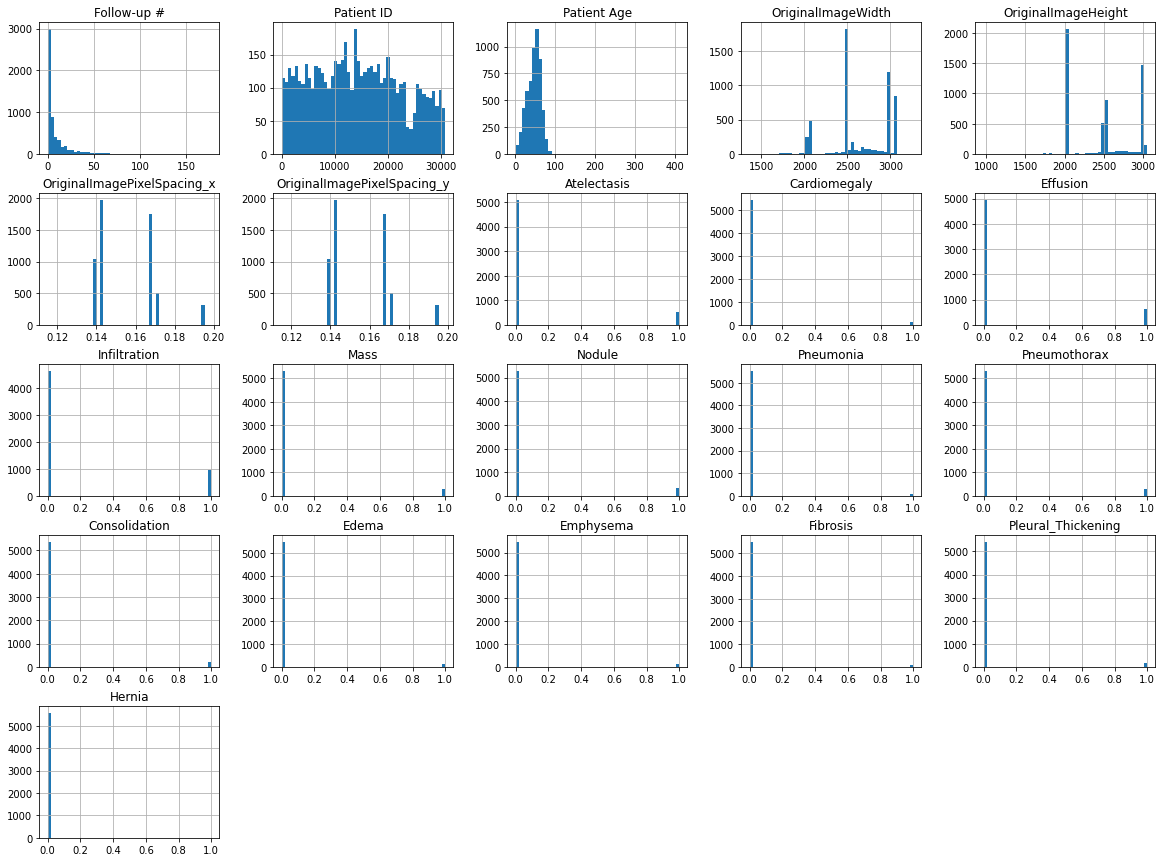

In [34]:
xray_data.hist(bins=50, figsize=(20,15))
plt.show()

In [44]:
all_labels = np.unique(list(chain(*[i.split('|') for i in xray_data['Finding Labels']])))
print(all_labels)

['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


In [47]:
for c_label in all_labels:
    xray_data[c_label] = xray_data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
xray_data.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia,targets,No Finding
2500,00012594_001.png,Nodule,1,12594,53,M,PA,2992,2991,0.143000,0.143000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
104,00000583_016.png,Effusion|Infiltration,16,583,40,F,AP,2500,2048,0.168000,0.168000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
3305,00016300_001.png,No Finding,1,16300,38,F,PA,2021,2021,0.194311,0.194311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.0


In [50]:
(xray_data[all_labels].sum()/len(xray_data)).nlargest(20)

No Finding            0.542990
Infiltration          0.172494
Effusion              0.114877
Atelectasis           0.090617
Nodule                0.055833
Mass                  0.050660
Pneumothorax          0.048341
Consolidation         0.040314
Pleural_Thickening    0.031395
Cardiomegaly          0.025152
Emphysema             0.022654
Edema                 0.021049
Fibrosis              0.014984
Pneumonia             0.011060
Hernia                0.002319
dtype: float64

In [52]:
xray_data[all_labels].corr()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Atelectasis,1.000000,0.008822,0.112216,0.001330,0.180535,0.035462,0.027560,0.049376,0.069693,0.000750,-0.344084,-0.009102,0.014437,0.031977,0.021563
Cardiomegaly,0.008822,1.000000,0.030787,0.039935,0.145768,0.006169,0.017697,-0.007744,0.002045,-0.005938,-0.175084,-0.019214,-0.002787,0.015692,-0.025579
Consolidation,0.112216,0.030787,1.000000,0.020488,0.105337,-0.006825,0.004581,-0.009881,0.043246,0.068443,-0.223407,0.005458,0.035909,0.082385,0.004545
Edema,0.001330,0.039935,0.020488,1.000000,0.044600,-0.013973,-0.007857,-0.007069,0.084352,-0.005541,-0.159833,-0.014009,-0.026399,0.150844,-0.027255
Effusion,0.180535,0.145768,0.105337,0.044600,1.000000,0.035379,0.010822,0.005892,0.091674,0.054524,-0.392688,0.024471,0.057042,0.004694,0.054427
Emphysema,0.035462,0.006169,-0.006825,-0.013973,0.035379,1.000000,0.010825,-0.007340,-0.006050,0.035894,-0.165953,-0.010917,0.027586,0.018288,0.155719
Fibrosis,0.027560,0.017697,0.004581,-0.007857,0.010822,0.010825,1.000000,0.024580,-0.001902,0.011680,-0.134439,0.001983,0.053575,-0.013043,-0.014106
Hernia,0.049376,-0.007744,-0.009881,-0.007069,0.005892,-0.007340,0.024580,1.000000,-0.002380,0.039595,-0.052551,-0.011724,-0.008680,-0.005098,0.006425
Infiltration,0.069693,0.002045,0.043246,0.084352,0.091674,-0.006050,-0.001902,-0.002380,1.000000,0.010790,-0.497661,0.043204,0.007151,0.055554,-0.010447
Mass,0.000750,-0.005938,0.068443,-0.005541,0.054524,0.035894,0.011680,0.039595,0.010790,1.000000,-0.251799,0.099703,0.065693,0.006682,0.076875


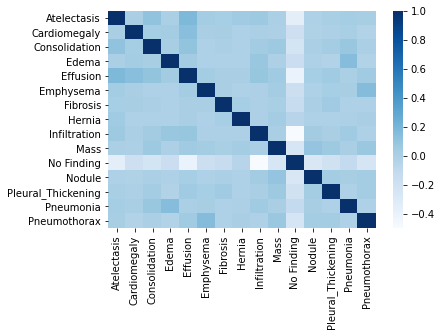

In [55]:
sns.heatmap(xray_data[all_labels].corr(), cmap='Blues')

In [60]:
!ls


sample_data


In [61]:
train, test = train_test_split(xray_data, test_size = 0.2)

In [62]:
print(len(train))
print(len(test))

4484
1122


In [63]:
type(train)

pandas.core.frame.DataFrame

In [64]:
def mk_train_generator(df, directory, x_col, y_col, labels):
    datagen = ImageDataGenerator(samplewise_center=True, 
                                 samplewise_std_normalization=True,
                                 rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 rescale=1./255,
                                 horizontal_flip=True)


    generator = datagen.flow_from_dataframe(dataframe=df, 
                                            x_col=x_col, 
                                            y_col=y_col, 
                                            classes=labels,
                                            class_mode='categorical',
                                            color_mode='grayscale',
                                            batch_size=32)
    
    return generator

In [23]:
datagen = ImageDataGenerator(samplewise_center=True, 
                                 samplewise_std_normalization=True,
                                 rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True)

In [65]:
training_set = mk_train_generator(train, './images/', 'Image Index', 'targets', labels)


Found 0 validated image filenames belonging to 14 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 4484 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [67]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [68]:
test_set = test_datagen.flow_from_dataframe(dataframe=test, 
                                            directory='./images/',
                                            x_col='Image Index',
                                            y_col='targets',
                                            classes=labels,
                                            class_mode='categorical',
                                            color_mode='grayscale',
                                            batch_size=32)

Found 0 validated image filenames belonging to 14 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1122 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [28]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [29]:
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape=(256,256,3), activation='relu'))

In [30]:
classifier.add(MaxPooling2D(pool_size=(2,2)))

In [31]:
classifier.add(Flatten())

In [32]:
classifier.add(Dense(units=128,activation='relu'))

In [34]:
classifier.add(Dense(units=1,activation='sigmoid'))

In [37]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
classifier.fit(training_set, batch_size=32,epochs=50)

ValueError: ignored

In [40]:
training_set